# 1006개의 데이터로 Transfer_Learning 하기

- VGG19 모델에 1006개의 데이터를 넣고 학습을 시켜보자
- Augmentation을 하였을 때와 하지 않았을 때의 성능의 차이를 살펴보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### GPU 사용 여부보기

In [2]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Running on multiple GPUs ['/device:GPU:0', '/device:GPU:1']
Number of accelerators: 2


#### 필요한 변수들 생성

In [3]:
IMAGE_SIZE = [256, 256]                    # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [5]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin_0601/CellPin
780
260
260


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'normal' in filename])
print('NORMAL images count in Train set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if 'cpe' in filename])
print('CPE images count in Train set :' + str(COUNT_CPE))

NORMAL images count in Train set :429
CPE images count in Train set :351


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if 'normal' in filename])
print('NORMAL images count in Validation set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if 'cpe' in filename])
print('CPE images count in Validation set :' + str(COUNT_CPE))

NORMAL images count in Validation set :143
CPE images count in Validation set :117


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if 'normal' in filename])
print('NORMAL images count in Test set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if 'cpe' in filename])
print('CPE images count in Test set :' + str(COUNT_CPE))

NORMAL images count in Test set :143
CPE images count in Test set :117


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Train images count :' + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validation images count :' + str(VAL_IMG_COUNT))

Train images count :780
Validation images count :260


#### 라벨 이름들 확인

In [13]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [14]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [17]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 3)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img   = tf.io.read_file(file_path)
    img   = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [18]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [19]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 좌우 반전
    image = tf.image.flip_up_down(image)     # 상하 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size = 1000, with_aug = False):
    if  with_aug:
        ds = ds.map(
            augment,  # augment 함수 적용
            num_parallel_calls = 2
            )    

    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

In [20]:
train_ds_no_aug = prepare_for_training(train_ds, with_aug = False)
val_ds_no_aug   = prepare_for_training(val_ds,   with_aug = False)
train_ds_aug    = prepare_for_training(train_ds, with_aug = True)
val_ds_aug      = prepare_for_training(val_ds,   with_aug = True)

#### Image shape를 변경 체크하기

In [21]:
for image, label in train_ds_no_aug.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape : (32, 256, 256, 3)
Label : (32,)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [23]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

260


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

In [24]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(ResNet, Freeze)

In [27]:
with strategy.scope():
    resnet_layer = tf.keras.applications.ResNet152V2(include_top           = False,
                                                     weights               = "imagenet",
                                                     input_shape           = (256, 256, 3),
                                                     classes               = 1,
                                                     classifier_activation = "sigmoid")
    
    fc_layer = [
        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation("sigmoid")
    ]
    
    resnet_layer.trainable = False
    
    no_aug_model   = tf.keras.models.Sequential([resnet_layer] + fc_layer)
    with_aug_model = tf.keras.models.Sequential([resnet_layer] + fc_layer)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [28]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 58,333,697
Trainable params: 2,049
Non-trainable params: 58,331,648
_________________________________________________________________


In [29]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 58,333,697
Trainable params: 2,049
Non-trainable params: 58,331,648
_________________________________________________________________


## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [30]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    no_aug_model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/ResNet152_FC_no_aug.h5")

In [31]:
with strategy.scope():
    with_aug_model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/ResNet152_FC_with_aug.h5")

#### 모델 fitting

In [32]:
with strategy.scope():
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_no_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [no_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 61s 1s/step - loss: 1.8624 - accuracy: 0.4891 - precision: 0.4020 - recall: 0.3657 - val_loss: 0.3507 - val_accuracy: 0.8516 - val_precision: 0.8110 - val_recall: 0.8803
Epoch 2/150
24/24 [==============================] - 23s 985ms/step - loss: 0.3401 - accuracy: 0.8418 - precision: 0.8153 - recall: 0.8490 - val_loss: 0.2068 - val_accuracy: 0.9102 - val_precision: 0.9259 - val_recall: 0.8696
Epoch 3/150
24/24 [==============================] - 24s 1s/step - loss: 0.2055 - accuracy: 0.9210 - precision: 0.9037 - recall: 0.9228 - val_loss: 0.1678 - val_accuracy: 0.9297 - val_precision: 0.9298 - val_recall: 0.9138
Epoch 4/150
24/24 [==============================] - 25s 1s/step - loss: 0.1603 - accuracy: 0.9291 - precision: 0.9297 - recall: 0.9240 - val_loss: 0.1575 - v

24/24 [==============================] - 22s 943ms/step - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1206 - val_accuracy: 0.9531 - val_precision: 0.9813 - val_recall: 0.9130
Epoch 73/150
24/24 [==============================] - 21s 930ms/step - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1155 - val_accuracy: 0.9570 - val_precision: 0.9817 - val_recall: 0.9224
Epoch 74/150
24/24 [==============================] - 22s 937ms/step - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1084 - val_accuracy: 0.9648 - val_precision: 0.9817 - val_recall: 0.9386
Epoch 75/150
24/24 [==============================] - 22s 936ms/step - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1196 - val_accuracy: 0.9531 - val_precision: 0.9813 - val_recall: 0.9130
Epoch 76/150
24/24 [==============================] - 22s 956ms/step - loss: 0.0043 - accuracy: 1.0000 - 

Epoch 144/150
24/24 [==============================] - 21s 930ms/step - loss: 0.0010 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1240 - val_accuracy: 0.9570 - val_precision: 0.9815 - val_recall: 0.9217
Epoch 145/150
24/24 [==============================] - 22s 945ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1297 - val_accuracy: 0.9570 - val_precision: 0.9818 - val_recall: 0.9231
Epoch 146/150
24/24 [==============================] - 21s 928ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1227 - val_accuracy: 0.9570 - val_precision: 0.9813 - val_recall: 0.9211
Epoch 147/150
24/24 [==============================] - 21s 931ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1287 - val_accuracy: 0.9570 - val_precision: 0.9813 - val_recall: 0.9211
Epoch 148/150
24/24 [==============================] - 22s 932ms/step - loss: 0.0011 - a

In [33]:
with strategy.scope():
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [with_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 56s 1s/step - loss: 0.2054 - accuracy: 0.9437 - precision: 0.9516 - recall: 0.9329 - val_loss: 0.1979 - val_accuracy: 0.9570 - val_precision: 0.9262 - val_recall: 0.9826
Epoch 2/150
24/24 [==============================] - 24s 1s/step - loss: 0.1495 - accuracy: 0.9494 - precision: 0.9431 - recall: 0.9500 - val_loss: 0.1725 - val_accuracy: 0.9570 - val_precision: 0.9339 - val_recall: 0.9741
Epoch 3/150
24/24 [==============================] - 24s 1s/step - loss: 0.1285 - accuracy: 0.9629 - precision: 0.9655 - recall: 0.9553 - val_loss: 0.1630 - val_accuracy: 0.9648 - val_precision: 0.9573 - val_recall: 0.9655
Epoch 4/150
24/24 [==============================] - 23s 1s/step - loss: 0.0689 - accuracy: 0.9757 - precision: 0.9735 - recall: 0.9738 - val_loss: 0.1659 - val_

24/24 [==============================] - 21s 928ms/step - loss: 0.0013 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1457 - val_accuracy: 0.9570 - val_precision: 0.9407 - val_recall: 0.9652
Epoch 73/150
24/24 [==============================] - 21s 923ms/step - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1462 - val_accuracy: 0.9531 - val_precision: 0.9478 - val_recall: 0.9478
Epoch 74/150
24/24 [==============================] - 21s 931ms/step - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1459 - val_accuracy: 0.9570 - val_precision: 0.9402 - val_recall: 0.9649
Epoch 75/150
24/24 [==============================] - 22s 967ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1450 - val_accuracy: 0.9531 - val_precision: 0.9478 - val_recall: 0.9478
Epoch 76/150
24/24 [==============================] - 22s 933ms/step - loss: 0.0012 - accuracy: 1.0000 - 

Epoch 108/150
24/24 [==============================] - 21s 915ms/step - loss: 6.4303e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1518 - val_accuracy: 0.9531 - val_precision: 0.9402 - val_recall: 0.9565
Epoch 109/150
24/24 [==============================] - 22s 944ms/step - loss: 7.6462e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9609 - val_precision: 0.9487 - val_recall: 0.9652
Epoch 110/150
24/24 [==============================] - 22s 940ms/step - loss: 7.3350e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1513 - val_accuracy: 0.9570 - val_precision: 0.9402 - val_recall: 0.9649
Epoch 111/150
24/24 [==============================] - 22s 944ms/step - loss: 5.4079e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1532 - val_accuracy: 0.9492 - val_precision: 0.9474 - val_recall: 0.9391
Epoch 112/150
24/24 [==============================] - 22s 937ms/step - 

## Step 5. 결과 확인 및 시각화

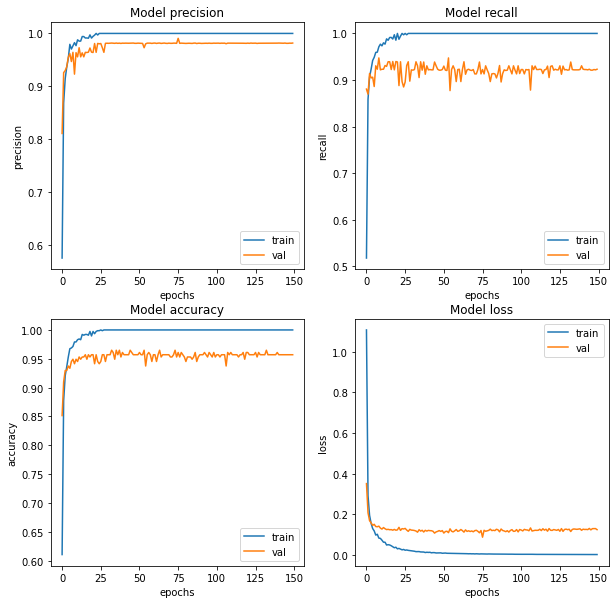

In [34]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

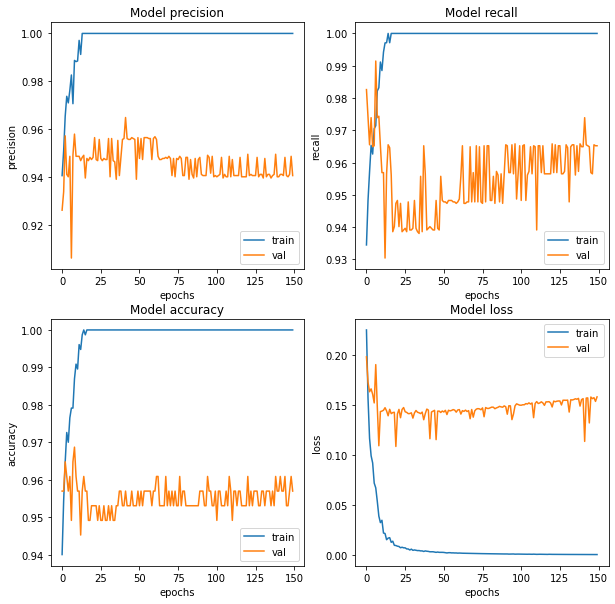

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. Test dataset 검정해보기

In [36]:
with strategy.scope():
    no_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/ResNet152_FC_no_aug.h5")

    loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

9/9 [==============================] - 10s 242ms/step - loss: 0.1648 - accuracy: 0.9500 - precision: 0.9483 - recall: 0.9402


In [37]:
with strategy.scope():
    with_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/ResNet152_FC_with_aug.h5")

    loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

9/9 [==============================] - 8s 186ms/step - loss: 0.1747 - accuracy: 0.9538 - precision: 0.9487 - recall: 0.9487


## Step 7. Freeze 풀고 다시 학습하기

#### augmentation 안한 모델 Freeze 풀어주기

In [38]:
with strategy.scope():
    no_aug_model.layers[0].trainable = True
    no_aug_model.layers[0].trainable

In [39]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 58,333,697
Trainable params: 58,189,953
Non-trainable params: 143,744
_________________________________________________________________


#### augmentation 한 모델 Freeze 풀어주기

In [40]:
with strategy.scope():
    with_aug_model.layers[0].trainable = True
    with_aug_model.layers[0].trainable

In [41]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 58,333,697
Trainable params: 58,189,953
Non-trainable params: 143,744
_________________________________________________________________


#### GPU를 사용하여 모델을 장착

In [42]:
with strategy.scope():
    no_aug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/ResNet152_no_aug.h5")

In [43]:
with strategy.scope():
    with_aug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/ResNet152_with_aug.h5")

#### 모델 학습

In [44]:
with strategy.scope():
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_no_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [no_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 514 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 514 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 127s 1s/step - loss: 11.5210 - accuracy: 0.5102 - precision: 0.6221 - recall: 0.9649 - val_loss: 0.7347 - val_accuracy: 0.8320 - val_precision: 0.9740 - val_recall: 0.6466
Epoch 2/150
24/24 [==============================] - 28s 1s/step - loss: 10.3198 - accuracy: 0.5200 - precision: 0.4847 - recall: 0.9540 - val_loss: 1.4711 - val_accuracy: 0.7656 - val_precision: 0.9828 - val_recall: 0.4914
Epoch 3/150
24/24 [==============================] - 27s 1s/step - loss: 10.3507 - accuracy: 0.5209 - precision: 0.4768 - recall: 0.9608 - val_loss: 1.4937 - val_accuracy: 0.7812 - val_precision: 0.9531 - val_recall: 0.5351
Epoch 4/150
24/24 [==============================] - 27s 1s/step - loss: 8.2826 - accuracy: 0.6029 - precision: 0.5389 - recall: 0.9634 - val_loss: 1.417

Epoch 37/150
24/24 [==============================] - 24s 1s/step - loss: 0.7309 - accuracy: 0.9047 - precision: 0.8897 - recall: 0.9009 - val_loss: 1.6701 - val_accuracy: 0.8516 - val_precision: 0.8545 - val_recall: 0.8103
Epoch 38/150
24/24 [==============================] - 23s 1000ms/step - loss: 0.9159 - accuracy: 0.8984 - precision: 0.8978 - recall: 0.8895 - val_loss: 1.6064 - val_accuracy: 0.8477 - val_precision: 0.8505 - val_recall: 0.7982
Epoch 39/150
24/24 [==============================] - 24s 1s/step - loss: 0.4859 - accuracy: 0.9380 - precision: 0.9022 - recall: 0.9572 - val_loss: 1.5979 - val_accuracy: 0.8594 - val_precision: 0.8624 - val_recall: 0.8174
Epoch 40/150
24/24 [==============================] - 23s 972ms/step - loss: 0.4935 - accuracy: 0.9341 - precision: 0.9208 - recall: 0.9381 - val_loss: 1.6713 - val_accuracy: 0.8594 - val_precision: 0.8692 - val_recall: 0.8087
Epoch 41/150
24/24 [==============================] - 24s 1s/step - loss: 0.4034 - accuracy: 0.94

24/24 [==============================] - 23s 977ms/step - loss: 0.0792 - accuracy: 0.9865 - precision: 0.9836 - recall: 0.9864 - val_loss: 1.4030 - val_accuracy: 0.8945 - val_precision: 0.9000 - val_recall: 0.8609
Epoch 110/150
24/24 [==============================] - 23s 989ms/step - loss: 0.0827 - accuracy: 0.9843 - precision: 0.9968 - recall: 0.9707 - val_loss: 1.2859 - val_accuracy: 0.8984 - val_precision: 0.9091 - val_recall: 0.8621
Epoch 111/150
24/24 [==============================] - 24s 1s/step - loss: 0.0725 - accuracy: 0.9854 - precision: 0.9737 - recall: 0.9930 - val_loss: 1.2625 - val_accuracy: 0.9062 - val_precision: 0.9174 - val_recall: 0.8696
Epoch 112/150
24/24 [==============================] - 23s 1s/step - loss: 0.0891 - accuracy: 0.9844 - precision: 0.9902 - recall: 0.9771 - val_loss: 1.2712 - val_accuracy: 0.9062 - val_precision: 0.9182 - val_recall: 0.8707
Epoch 113/150
24/24 [==============================] - 23s 1s/step - loss: 0.0318 - accuracy: 0.9946 - preci

In [45]:
with strategy.scope():
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [with_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 514 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 514 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 120s 1s/step - loss: 19.3144 - accuracy: 0.5135 - precision: 0.6094 - recall: 0.9328 - val_loss: 0.9378 - val_accuracy: 0.8477 - val_precision: 0.9753 - val_recall: 0.6810
Epoch 2/150
24/24 [==============================] - 24s 1s/step - loss: 17.0091 - accuracy: 0.5458 - precision: 0.5063 - recall: 0.9930 - val_loss: 1.3596 - val_accuracy: 0.8203 - val_precision: 0.9605 - val_recall: 0.6293
Epoch 3/150
24/24 [==============================] - 24s 1s/step - loss: 14.7278 - accuracy: 0.5599 - precision: 0.5103 - recall: 0.9820 - val_loss: 1.4063 - val_accuracy: 0.8320 - val_precision: 0.9167 - val_recall: 0.6814
Epoch 4/150
24/24 [==============================] - 23s 998ms/step - loss: 13.8423 - accuracy: 0.5678 - precision: 0.5130 - recall: 0.9875 - val_loss: 1

24/24 [==============================] - 24s 1s/step - loss: 0.3899 - accuracy: 0.9652 - precision: 0.9515 - recall: 0.9634 - val_loss: 1.8256 - val_accuracy: 0.8750 - val_precision: 0.8739 - val_recall: 0.8435
Epoch 73/150
24/24 [==============================] - 23s 976ms/step - loss: 0.2003 - accuracy: 0.9841 - precision: 0.9736 - recall: 0.9901 - val_loss: 1.8151 - val_accuracy: 0.8945 - val_precision: 0.9000 - val_recall: 0.8609
Epoch 74/150
24/24 [==============================] - 23s 965ms/step - loss: 0.1319 - accuracy: 0.9848 - precision: 0.9854 - recall: 0.9810 - val_loss: 1.7796 - val_accuracy: 0.8906 - val_precision: 0.8850 - val_recall: 0.8696
Epoch 75/150
24/24 [==============================] - 24s 1s/step - loss: 0.4678 - accuracy: 0.9716 - precision: 0.9572 - recall: 0.9808 - val_loss: 1.7604 - val_accuracy: 0.8906 - val_precision: 0.9074 - val_recall: 0.8448
Epoch 76/150
24/24 [==============================] - 23s 974ms/step - loss: 0.1544 - accuracy: 0.9766 - precis

24/24 [==============================] - 23s 999ms/step - loss: 0.0637 - accuracy: 0.9915 - precision: 0.9977 - recall: 0.9841 - val_loss: 1.4638 - val_accuracy: 0.9102 - val_precision: 0.9182 - val_recall: 0.8783
Epoch 145/150
24/24 [==============================] - 23s 1s/step - loss: 0.0694 - accuracy: 0.9897 - precision: 0.9841 - recall: 0.9925 - val_loss: 1.6845 - val_accuracy: 0.8984 - val_precision: 0.9159 - val_recall: 0.8522
Epoch 146/150
24/24 [==============================] - 24s 1s/step - loss: 0.0436 - accuracy: 0.9941 - precision: 0.9939 - recall: 0.9928 - val_loss: 1.7595 - val_accuracy: 0.8984 - val_precision: 0.9159 - val_recall: 0.8522
Epoch 147/150
24/24 [==============================] - 24s 1s/step - loss: 0.2432 - accuracy: 0.9737 - precision: 0.9565 - recall: 0.9834 - val_loss: 1.6486 - val_accuracy: 0.9023 - val_precision: 0.9167 - val_recall: 0.8609
Epoch 148/150
24/24 [==============================] - 23s 989ms/step - loss: 0.0526 - accuracy: 0.9938 - preci

#### 시각화

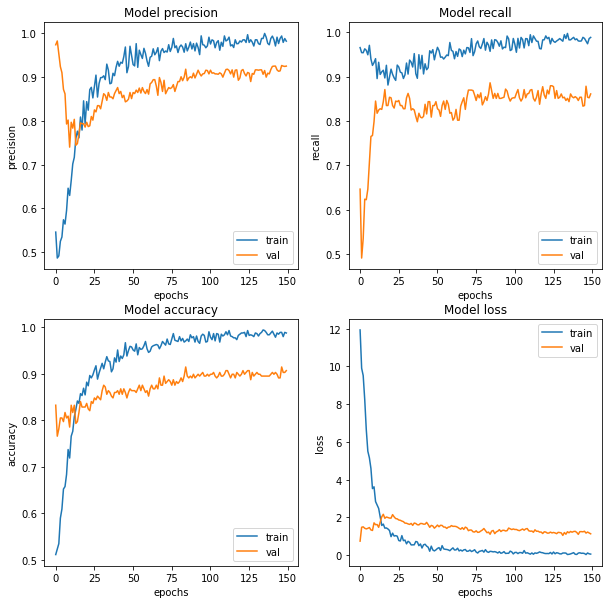

In [46]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

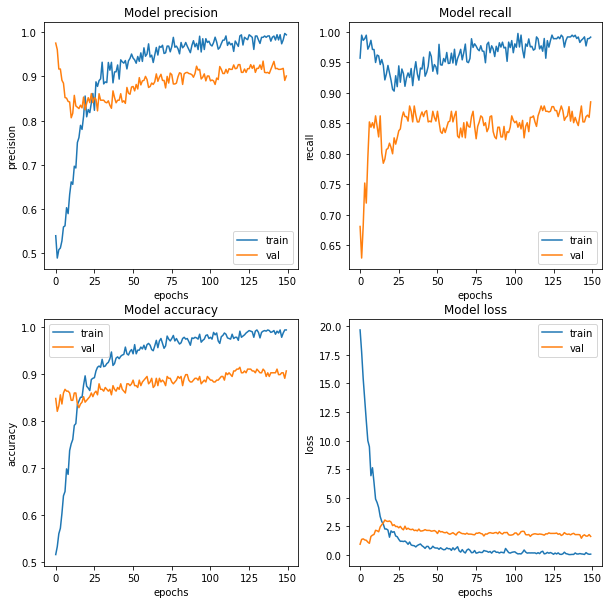

In [47]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

#### 최종 결과 확인

In [48]:
with strategy.scope():
    no_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/ResNet152_no_aug.h5")

    loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

9/9 [==============================] - 5s 219ms/step - loss: 0.9687 - accuracy: 0.9115 - precision: 0.9273 - recall: 0.8718


In [49]:
with strategy.scope():
    with_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/ResNet152_with_aug.h5")

    loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

9/9 [==============================] - 5s 219ms/step - loss: 2.3518 - accuracy: 0.8808 - precision: 0.8468 - recall: 0.8974
